In [54]:
features = {}
def hook_fn(module, input, output):
    features['pre_head'] = output.detach()  

In [ ]:
# load PDDD model
import torch
from PDDD.Codes.modelpy.visual_model.ResNet_50_101_152 import ResNet152
from PDDD.Codes.modelpy.visual_model.ViT_L import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo kiến trúc mô hình trước
model = VisionTransformer()

# Load trọng số đã lưu
model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ViT_L.std"
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model=model.to(device)

model_name = os.path.basename(model_path)

model.eval()  # Đặt model ở chế độ inference

In [ ]:
# load PDDD model
import torch
from PDDD.Codes.modelpy.visual_model.ResNet_50_101_152 import ResNet152
from PDDD.Codes.modelpy.visual_model.ViT_L import VisionTransformer

# Khởi tạo kiến trúc mô hình trước
model = ResNet152()

# Load trọng số đã lưu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ResNet152.std"
model.load_state_dict(torch.load(model_path, map_location=device))
# model.fc = torch.nn.Identity()
model=model.to(device)

model_name = os.path.basename(model_path)
hook_handle = model.avgpool.register_forward_hook(hook_fn)

model.eval()  # Đặt model ở chế độ inference


In [ ]:
# load eva02_large_patch14_clip_336 from timm
import timm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "hf_hub:timm/eva02_large_patch14_clip_336.merged2b_ft_inat21"
model = timm.create_model(model_path, pretrained=True)
# model = torch.nn.Sequential(*list(model.children())[:-1]).to(device)
model = model.to(device)

model_name = os.path.basename(model_path)
hook_handle = model.norm.register_forward_hook(hook_fn)

model.eval() 

## Run model

### Read data

In [2]:
# read PDDD anotation
%store -r image_dict
def get_PDDD_info(image_id):
    img_info = image_dict[image_id]
    return img_info["file_name"]

%store -r category_dict
def get_PDDD_category(category_id):
    return category_dict[category_id]

%store -r image_paths labels

# from collections import Counter
# list = Counter(labels)

image_paths[:2], labels[:2], len(image_paths), len(labels)

(['/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomate_Taches_Brunes-122-_jpg.rf.a3f5716e27e5be00a300906d166797ed_7610_Tomato Brown Spots.jpg',
  '/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomate_Taches_Brunes-342-_jpg.rf.14d6bc4f4f81367b610c2e671e6a8c47_704_Tomato Brown Spots.jpg'],
 ['Tomato Brown Spots', 'Tomato Brown Spots'],
 2786,
 2786)

In [94]:
# common utils
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns
from tqdm import tqdm

# Transform cho ảnh
transform = transforms.Compose([
        transforms.Resize(336, interpolation=Image.BICUBIC),
        transforms.CenterCrop(336),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ])

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.416, 0.468, 0.355], std=[0.210, 0.206, 0.213]),
# ])

###############################    
def load_image(image_path):
    if image_path.startswith('http'):
        # Download image from URL
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        # Load local image
        image = Image.open(image_path).convert('RGB')
    return image

### Test

In [101]:
image = load_image('/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd66077d50344a_7246_Corn Smut.jpg')
embedding = get_image_embedding(model,image)
print(embedding.shape)

torch.Size([1, 577, 1024])
(1, 590848)


### Predict 

In [ ]:
# run prediction
pred_labels = []
confidences = []
for image_path in tqdm(image_paths[:10]):
    pred_class_id, confidence = predict_plant(image_path)
    # pred_label = get_PDDD_category(pred_class_id)
    pred_labels.append(pred_class_id)
    confidences.append(confidence)

pred_labels[:10], confidences[:10]

In [ ]:
# pretrained utils
def predict_plant(image_path):
    """Predict plant species and return class ID and confidence"""
    image = load_image(image_path)
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        confidence, pred_class = torch.topk(probs, 1)
    return pred_class.item(), confidence.item()

In [ ]:
# embedding utils
def get_image_embedding(model, image, device='gpu'):
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor)
        embedding = torch.nn.functional.normalize(embedding, dim=1)
    return embedding.squeeze(0).cpu().numpy()

def create_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

# ===== EMBED & INDEX ALL IMAGES =====
def run_model(image_paths, model):
    embeddings = []
    features = []
    for i,path in enumerate(tqdm(image_paths, desc="Embedding images")):
        image = load_image(path)
        vec = get_image_embedding(model, image, device)
        embeddings.append(vec)

        # feature = get_features(image,kernel_size=(circle,circle),sigmaX=circle/2)
        # features.append(feature)

    embeddings = np.stack(embeddings) 
    index = create_index(embeddings)
    return index, embeddings 

# index, features = inference(image_paths, model,1)

def inference(model,index,embedding,i):
        query_vec = embedding.reshape(1, -1)
        distance, result = index.search(query_vec, k=2)  # i: nearest vector, D: distance
        top1 = result[0][1] if result[0][0] == i else result[0][0]
        return top1,distance

# Evaluate
def evaluate(index, labels, embeddings):
    correct = 0
    total = len(labels)
    pred_labels = []
    distances = []
    for i in range(total):
        top1, distance = inference(model,index,embeddings[i],i)
        pred_labels.append(labels[top1])
        distances.append(distance)
        if labels[i] == labels[top1]:
            correct += 1

    accuracy = correct / total
    return accuracy, pred_labels, distances

In [ ]:
import pandas as pd
df = pd.DataFrame(pred_labels)
df['confidence'] = confidences

In [ ]:
df[(df['confidence'] >= 0.5) & (df['common_name'] == 'tomato')]

In [ ]:
df[(df['confidence'] >= 0.5) & (df['common_name'] != 'tomato')]

In [ ]:
image = load_image(image_paths[8])
plt.imshow(image)

### Embedding

In [102]:
# create embedding
import torch
from torchvision import models, transforms
from tqdm import tqdm
import faiss

def model_forward(model_name, tensor):
    # match model_name:
    #     case 'ResNet',:
    #         return model(tensor)
    #     case 'eva02_large_patch14_clip_336.merged2b_ft_inat21':
    #         return model.forward_features(tensor)

    output = model(tensor)  
    embedding = features['pre_head']
    return embedding
        
def get_image_embedding(model, image, device='cuda'):
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model_forward(model_name,img_tensor)  # lấy token embeddingput
        # if isinstance(embedding, (tuple, list)):
        #     embedding = embedding[0]
        # embedding = embedding[:, 0]  # lấy CLS token
        # embedding = torch.nn.functional.normalize(embedding, dim=1)
    return embedding.squeeze(0).cpu().numpy().reshape(1, -1)

def create_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def run_model(image_paths, labels):
    embeddings = []
    for path, label in tqdm(list(zip(image_paths, labels)), desc="Extract embeddings"):  # giới hạn 300 ảnh
        img = Image.open(path).convert("RGB")
        vec = get_image_embedding(model, img)
        embeddings.append(vec)
    hook_handle.remove()  
    return embeddings

embeddings = run_model(image_paths[:2], labels)
embeddings_np = np.array(embeddings).astype("float32").squeeze(1)  # FAISS cần float32
index = create_index(embeddings_np)

Extract embeddings: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s]


### File IO

In [ ]:
# init path
import os
import faiss
import numpy as np
import json
dir_path = '/media/icnlab/Data/Manh/tinyML/FieldPlant-11'
index_path = os.path.join(dir_path,f'{model_name}_tomatocropped.index')
json_path = os.path.join(dir_path,f'{model_name}_tomatocropped.json')

In [ ]:
# save index
faiss.write_index(index, index_path)

# save class mapping (index -> class_id)
with open(json_path, "w") as f:
    json.dump(labels, f)

size_on_disk = os.path.getsize(index_path) / (1024 * 1024)
print(f"FAISS index file size: {size_on_disk:.2f} MB")
len(labels)

FAISS index file size: 21.77 MB


2786

In [ ]:
# Read faiss database
import faiss
import json
import os
model_name = 'eva02'
dir_path = os.path.dirname(dataset_path)
index_path = os.path.join(dir_path,f'{model_name}_tomato.index')
json_path = os.path.join(dir_path,'single_tomato.json')

# Đọc index từ file
index = faiss.read_index(index_path)
embeddings = index.reconstruct_n(0, index.ntotal)

# Đọc label mapping
with open(json_path, "r") as f:
    labels = json.load(f)  
    
len(labels), len(embeddings)

### Plot embedding space

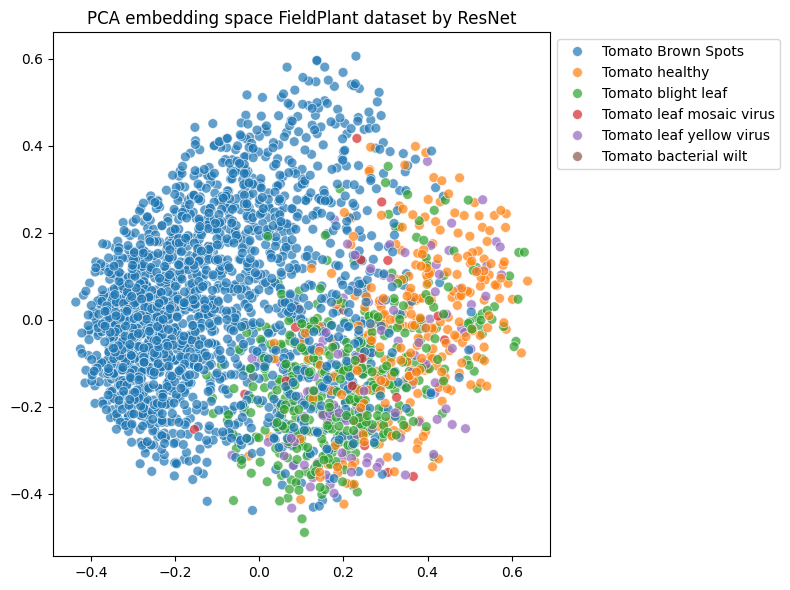

In [ ]:
# PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Giảm chiều bằng PCA hoặc t-SNE
X = np.array(embeddings) # turn list => array (n_samples, n_features) 
pca = PCA(n_components=2) # n_features => 2 features
X_reduced = pca.fit_transform(X)

# Vẽ
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7)
plt.title(f"PCA embedding space FieldPlant dataset by {model_name}")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()